# Gaussian Mixture Model (GMM)
Is a probabilistic model, that can be used as a clustering model. One different with K-Means is that here we have probabilities of one point of belonging to a cluster, (KMeans assing each point to a cluster directly) but GMM take the maximum probability and returns the cluster to which that point belongs, however you can use the method **predict_proba** to see the probability of each cluster.

It's based in the covariance matrix of the features

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from mpl_toolkits import mplot3d
from pandas_profiling import ProfileReport

In [49]:
df_online_customers = pd.read_csv('C:/Users/alberto.rubiales/PycharmProjects/Pycharm/Gaussian Mixture Model/online_shoppers_intention.csv')
df_online_customers[:10]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.000000,0.100000,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.200000,0.200000,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.050000,0.140000,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.020000,0.050000,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
5,0.0,0.0,0.0,0.0,19.0,154.216667,0.015789,0.024561,0.0,0.0,Feb,2,2,1,3,Returning_Visitor,False,False
6,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.200000,0.200000,0.0,0.4,Feb,2,4,3,3,Returning_Visitor,False,False
7,1.0,-1.0,0.0,-1.0,1.0,-1.000000,0.200000,0.200000,0.0,0.0,Feb,1,2,1,5,Returning_Visitor,True,False
8,0.0,0.0,0.0,0.0,2.0,37.000000,0.000000,0.100000,0.0,0.8,Feb,2,2,2,3,Returning_Visitor,False,False
9,0.0,0.0,0.0,0.0,3.0,738.000000,0.000000,0.022222,0.0,0.4,Feb,2,4,1,2,Returning_Visitor,False,False


In [ ]:
ProfileReport(df_online_customers)

This dataset have a huge quantity of outliers, so i will create a function that drop the outliers and apply several times

In [59]:
def outlier_cleaner(df, sigma=3):
    '''
    A function to clear all the outliers of a dataframe
    
    :param df: The dataframe to clean outliers
    :param sigma: The z_score threshold to remove a value, by default 3
    :return: the dataframe with the outliers removed
    '''
    for col in df.columns:
        column_data = df[col]
        mean = np.mean(column_data)
        std = np.std(column_data)
        

        outliers = []
        counter = 0
        
        for data in column_data:
            z_score = (data -mean)/std
            if np.abs(z_score) >= sigma:
                outliers.append(counter)
            counter += 1
            
        df.drop(df.index[outliers], inplace=True)

    df.reset_index(drop=True, inplace=True)
    return df

In [69]:
df_online_customers = df_online_customers[['ProductRelated_Duration', 'Administrative_Duration', 'Informational_Duration']]
df_online_customers = outlier_cleaner(df_online_customers)
df_online_customers = outlier_cleaner(df_online_customers)
df_online_customers = outlier_cleaner(df_online_customers)
df_online_customers.dropna(inplace=True)
print('Shape', df_online_customers.shape)
df_online_customers[:5]

Shape (9916, 3)


,ProductRelated_Duration,Administrative_Duration,Informational_Duration
0,0.000000,0.0,0.0
1,64.000000,0.0,0.0
2,-1.000000,-1.0,-1.0
3,2.666667,0.0,0.0
4,627.500000,0.0,0.0


<IPython.core.display.Javascript object>


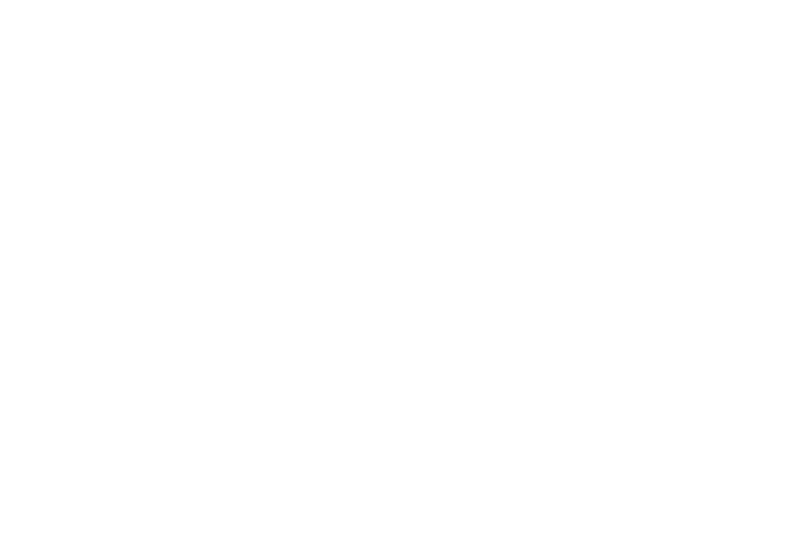

<IPython.core.display.Javascript object>


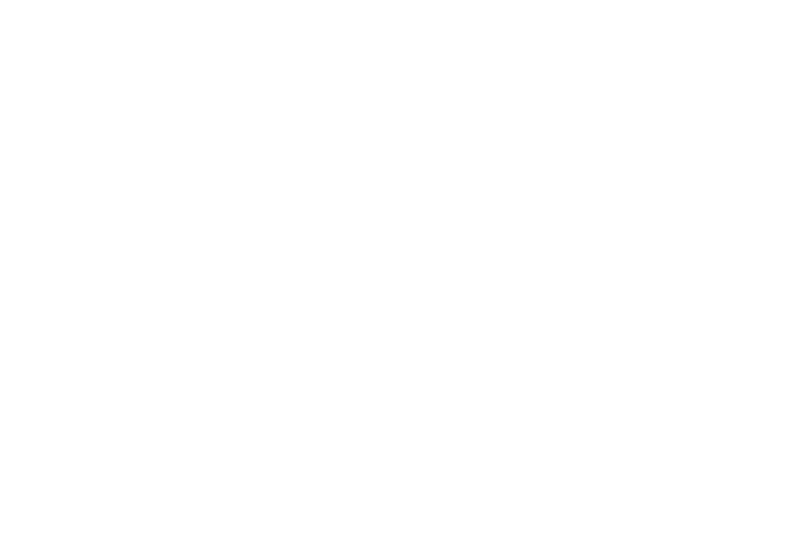

Number of variables,4
Number of observations,9916
Total Missing (%),0.0%
Total size in memory,310.0 KiB
Average record size in memory,32.0 B
Numeric,4
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [70]:
ProfileReport(df_online_customers)

In [ ]:
%matplotlib notebook

## GMM Hyperparameters
* n_components: the number of clusters (here are called components) that we want
* covariance_type: there are 3 types of covariance matrix:
    * diag: each component has its own diagonal covariance matrix, this helps plain clusters
    * tied: all components share the same general covariance matrix, this helps eliptical clusters
    * spherical: each component has its own single variance, this helps sheprical clusters
    * full: each component has its own general covariance matriz, this helps the most eliptical and tiny clusters
* reg_covar:the regularization added to the covariance matrix in order to avoid negative number
* init_params: the method that initialize the components, could be:
    * kmeans: the kmeans algorithm initialize the components
    * random: in the first interation the components are located ramdomly
* weights_init: to pass weights to the algorithm
* means_init: to pass the initial means to the algorithm
* precisions_init: to pass the initial inverse of the convariance matrix
* warm_start: True/False, if True, the last fit iteration is pased to the next iteration, instead of the init param. This is to speed up convergence

![covariance types](https://scikit-learn.org/0.15/_images/plot_gmm_classifier_0011.png)

In [115]:
gmm = GaussianMixture(n_components=2,
                      covariance_type="diag",
                      max_iter = 1000,
                      random_state=2018)
preds = gmm.fit_predict(df_online_customers)

In [116]:
#Covariance matrix of each cluster
gmm.covariances_

array([[5.55303858e+05, 3.02385419e+03, 1.00000000e-06, 1.00000000e-06],
       [7.70189061e+05, 5.08375845e+03, 3.92576422e+02, 1.00000000e-06]])

In [117]:
#Means matrix of each cluster
gmm.means_

array([[6.75491057e+02, 3.21088534e+01, 0.00000000e+00, 0.00000000e+00],
       [1.16744911e+03, 6.83870465e+01, 2.88443000e+01, 1.00000000e+00]])

In [118]:
#Weights of each cluster
gmm.weights_

array([0.91044776, 0.08955224])

In [73]:
df_online_customers['preds'] = preds

In [106]:
silhouette_score(df_online_customers, preds)

0.2066744735106361

<IPython.core.display.Javascript object>


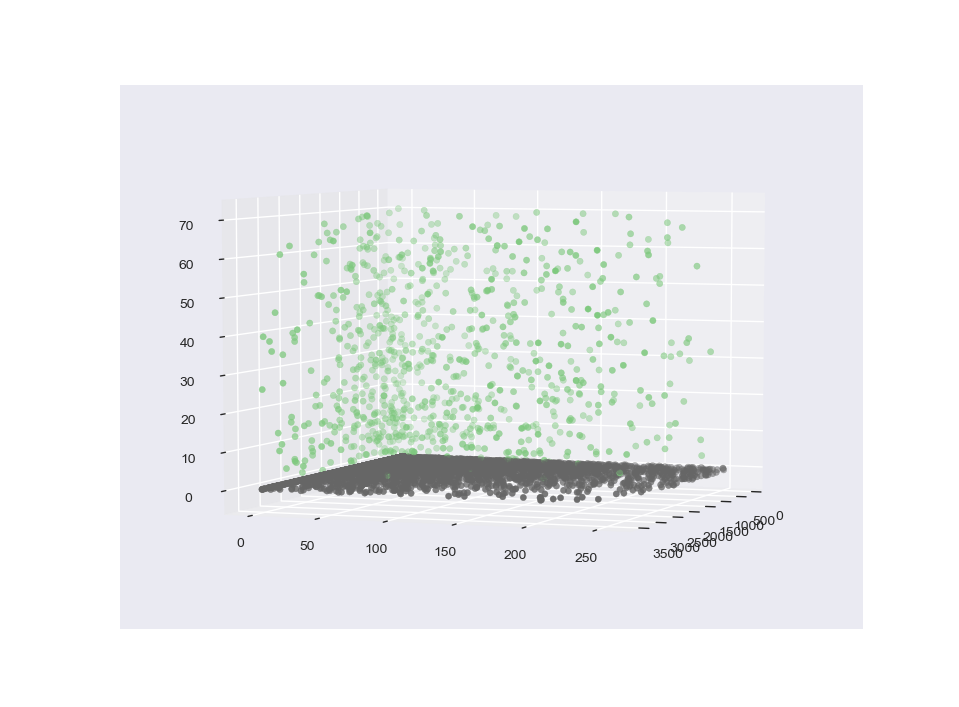

In [74]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection="3d")
ax.scatter3D(df_online_customers['ProductRelated_Duration'], df_online_customers['Administrative_Duration'], df_online_customers['Informational_Duration'], c=preds, cmap='Accent_r')
plt.show()

## Conclusions of our data
We can see that there is  2 clusters in our data, so our clients are segmented in 2 kinds of differents customers:
* Cluster 0: are our clients with less informational duration
* Cluster 1: are our clients with more informational duration

This model is not good, we have a low silouthe coefficient as a we see in the plot, some points are very near one each other
## Conclusions of GMM algorithm

### Pros
* Easy to understund 
* Is one of the most knowleged cluster algorithm
* Clusters (Components are callçed in this algorithm) don't have to be spherical

### Cons

* We need to say to the cluster the number of cluster that we want. there are methods to infer the number of clusters but they are not at all good (we will talk about this methods in another notebook).
* The algorithm does not discard points, all points of the dataset belong to a cluster, even if they are extremely far away, sometimes the algorithm segment noise as other cluster.
